# Film de la variance moyennee

La variance est définie comme le carré de la différence entre le champ de vorticité relatif total et filtré via un filtre de Lanczos passe-bas (celui donné dans cdftools, cdfsmooth), de telle sorte à couper les structures de taille inférieure à 2°, moyenné en temps sur un mois, puis en espace sur des cases de 1°x1° (des moyennes temporelles).

Fait dans le fichier *Variance filtrée Lanczos* dont on importe les sorties ici.

Animation mp4 sur une année en sortie.

 - auteur : Sylvie Su
 - date : Avril 2016

## Import modules

In [1]:
import sys
sys.path.append('/home/users/su8sy/lib/python/')

import numpy as np
import dask
import xarray as xr
import GriddedData
import time

In [2]:
#- Other modules
import os, sys
from glob import glob
import numpy.ma as ma
import scipy as sc
import WavenumberSpectrum as ws

### palette
import matplotlib.cm as mplcm
import colormaps as cmaps
import matplotlib.cm as cm
#cm.register_cmap(name='viridis', cmap=cmaps.viridis)
#import seaborn as sns
#seq_cmap = cmaps.viridis # future default matplotlib
seq_cmap = mplcm.Blues
div_cmap = mplcm.seismic

### quick plot
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
%matplotlib inline

### for animated plot
import pylab as m
from matplotlib import animation

## Data

In [51]:
#files = glob('/scratch/su8sy/Data/CURLOVERF/varm1x1deg_L120_NATL60-MJM155_y2008m*.1d_CURLOVERF.nc')
files = glob('/fsnet/data/meom/MODEL_SET/NATL60/NATL60-MJM155-S/1d/CURLOVERF/varm1x1deg_L120_NATL60-MJM155_y2008m*.1d_CURLOVERF.nc')
#files = glob('/scratch/su8sy/Data/BUOYANCYFLX/varm1x1deg_L120_NATL60-MJM155_y2008m*.1d_VOSIGMA0.nc')
#files = glob('/scratch/su8sy/Data/SPICYNESS/varm1x1deg_L120_NATL60-MJM155_y2008m*.1d_sosstsst.nc')
#files= glob('/home/users/su8sy/Data/hp_L120_NATL60-MJM155_y2008m*.1d_CURLOVERF.nc')

In [52]:
ds = xr.open_mfdataset(files,concat_dim='time')
#ds = xr.open_mfdataset(files)#,concat_dim='time')

In [53]:
#var = ds['variance_sosaline']
#var = ds['variance_vosigma0'].squeeze()
var = ds['variance_socurloverf'].squeeze()
#var = ds['variance_sosst'].squeeze()
#hpcurl = ds['socurloverf']
navlon = np.array(ds["nav_lon"][0])
navlat = np.array(ds["nav_lat"][0])
#print type(varcurl)
#print type(navlon)
print var.shape
print navlon.shape
print navlon

(12, 57, 90)
(57, 90)
[[-80.95160675 -79.95165253 -78.95175934 ...,   6.05292225   7.05296803
    8.05300617]
 [-80.9526062  -79.95291138 -78.95283508 ...,   6.05478287   7.05487442
    8.05493355]
 [-80.95419312 -79.95420837 -78.95435333 ...,   6.05741739   7.05753374
    8.05767155]
 ..., 
 [-85.07791901 -84.20748138 -83.33272552 ...,  13.30935955  14.39742851
   15.47490883]
 [-85.3152771  -84.45274353 -83.58622742 ...,  13.73867512  14.83087826
   15.91182518]
 [-85.56240845 -84.70859528 -83.85028076 ...,  14.18800354  15.28441048
   16.3688488 ]]


## Movie

In [54]:
print var[0,:500,:500].values

[[        nan         nan         nan ...,         nan         nan
          nan]
 [        nan         nan  0.06606755 ...,         nan         nan
          nan]
 [        nan  0.26623792  0.02359379 ...,         nan         nan
          nan]
 ..., 
 [        nan         nan         nan ...,         nan         nan
          nan]
 [        nan         nan         nan ...,         nan         nan
          nan]
 [        nan         nan         nan ...,         nan         nan
          nan]]


In [55]:
ChampVar = ma.masked_invalid(var)
lonVar = navlon
latVar = navlat

print ds["nav_lon"]
print navlat.shape

<xarray.DataArray 'nav_lon' (time: 12, y: 57, x: 90)>
dask.array<concate..., shape=(12, 57, 90), dtype=float32, chunksize=(1, 57, 90)>
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * y        (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 10 11
(57, 90)


In [56]:
#animation.FuncAnimation?

In [57]:
class animationGeneral(object):
# First set up the figure, the axis, and the plot element we want to animate
    def __init__(self, champ, stepNum,lon,lat,vmin,vmax,animationname):
        #Global definitions
        self.MassVar=champ
        self.lonVar=lon
        self.latVar=lat
        self.t=0
        self.vmin=vmin
        self.vmax=vmax

        #Figure
        self.fig = plt.figure(figsize=(15,10))

        ##Axes definition
        self.ax = plt.axes(projection=ccrs.PlateCarree())
        #self.ax.set_extent([-200, 200, -45, -45],ccrs.PlateCarree())
        self.ax.coastlines(resolution="10m",color='k')
        self.ax.gridlines(draw_labels=True)
        #The plot to animate
        self.plot2=plt.pcolormesh(lonVar,latVar,self.MassVar[0,:,:]
            ,vmax=self.vmax
            ,vmin=self.vmin
            ,cmap=seq_cmap
            #, norm = LogNorm()
            ,transform=ccrs.PlateCarree()
            ,edgecolor='none'
            #,s=0.6
            )

        self.fig.suptitle('Month: ',fontsize=20)
        
        cbar=plt.colorbar(self.plot2, orientation='horizontal', pad=0.04)
        #cbar.set_label('Sea Surface Temperature Variance')
        cbar.set_label('Relative Voricity Variance')
        self.ax.set_aspect('auto', adjustable=None)

        ##Adding my own Antarctica graphics
        #drawAntarctica(self.ax)

        ##Animation definition
        anim = animation.FuncAnimation(self.fig, self.update, np.arange(stepNum),interval=1000,blit=False)

        ##Writer FFMpeg needed for mp4 film
        mywriter = animation.FFMpegWriter()
        anim.save(animationname, writer=mywriter,fps=1,extra_args=['-vcodec', 'libx264'])
    
    #No init_plot needed
    #def setup_plot(self):
    
    # animation function to be called nsteps times plus the initialisation since init_func isn't defined
    def update(self,i):
        t=i
        print t,'setup'

        ##Index of the dat to be extrated
        #index=np.where(self.MassVar[t,:,:]*(self.latVar[:,:]<-30)!=0.)
        ##Remove previous data plotted
        self.plot2.remove()
        ##The plot
        self.plot2=plt.pcolormesh(lonVar,latVar,self.MassVar[t,:,:]
            #, c=self.MassVar[t,index[0],index[1]]
            ,vmax=self.vmax
            ,vmin=self.vmin
            ,cmap=seq_cmap
            #, norm = LogNorm()
            ,transform=ccrs.PlateCarree()
            ,edgecolor='none'
            #,s=0.6
            )
        self.fig.suptitle('Month: ' + month[t],fontsize=20, horizontalalignment='left')
        return self.plot2,    

    def show(self):
        plt.show()

0 setup
0 setup
1 setup
2 setup
3 setup
4 setup
5 setup
6 setup
7 setup
8 setup
9 setup
10 setup
11 setup


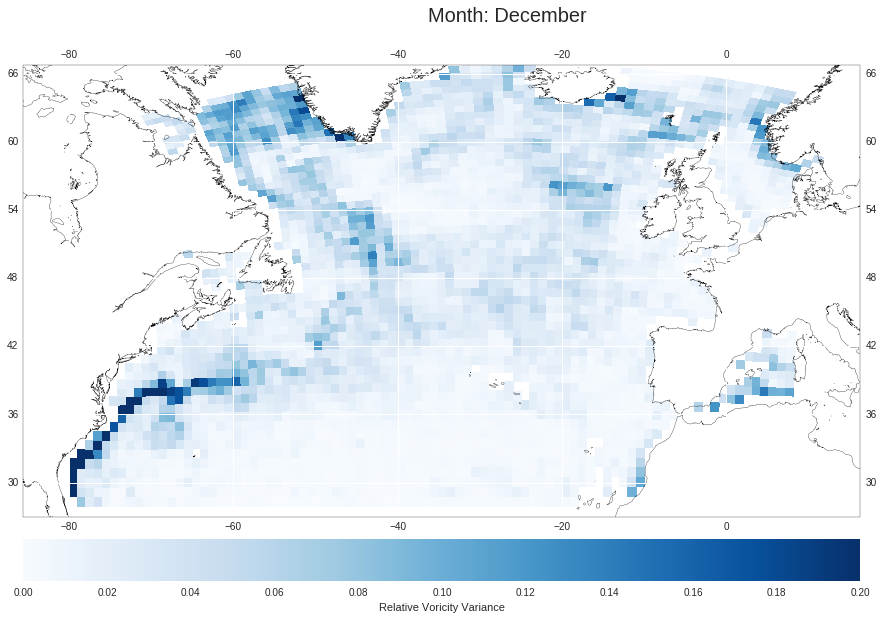

In [58]:
##fichier de sortie
outdir = '/home/users/su8sy/Figures'
#animationname = outdir + '/varvosigma0_month_1x1deg01.mp4'
animationname = outdir + '/curlvar02b.mp4'

month=['January','February','March','April','May','June','July','August','September','October','November','December']
##animationGeneral(Field I want to plot,
# Time steps ,
# Longitude Field,
# Latitude Field,
# Min Value of the colorbar,
# Max Value of the colorbar,
# File name
#a = animationGeneral(ChampVar,12,lonVar[:500,:500],latVar[:500,:500],-1,1,animationname)
a = animationGeneral(ChampVar,12,lonVar,latVar,0,0.2,animationname)

##Show at the end
#a.show()